# Recurent text gen

In [42]:
import tqdm
import json
import kagglehub
import numpy as np
import pandas as pd
from random import sample
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory 

import torch
from torch import nn

import huggingface_hub
hf_api = huggingface_hub.HfApi()

from pathlib import Path
files_path = Path("recurent_layer_files")
files_path.mkdir(exist_ok=True)

path = kagglehub.dataset_download("Cornell-University/arxiv/versions/205")
path = Path(path)/"arxiv-metadata-oai-snapshot.json"

In [ ]:
data_path = files_path/"arxiv_small.json"

if not data_path.exists():
    
    LINES = []
    with open(path, "r") as f:
        for i, one_line in enumerate(tqdm.tqdm(f.readlines())):
            if i % 10 == 0:
                LINES.append(one_line)

    with open(data_path, mode="w") as f:
        f.writelines(LINES)

data = pd.read_json(data_path, lines=True)

In [3]:
BOS, EOS = " ", "\n"
LINES = (
    data
    .apply(lambda row: (row["title"] + " ; " + row["abstract"])[:512], axis=1)
    .apply(lambda line: BOS + line.replace(EOS, " ") + EOS)
    .tolist()
)

LINES[:3]

[' Calculation of prompt diphoton production cross sections at Tevatron and   LHC energies ;   A fully differential calculation in perturbative quantum chromodynamics is presented for the production of massive photon pairs at hadron colliders. All next-to-leading order perturbative contributions from quark-antiquark, gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as all-orders resummation of initial-state gluon radiation valid at next-to-next-to-leading logarithmic accuracy. The region o\n',
 ' Computing genus 2 Hilbert-Siegel modular forms over $\\Q(\\sqrt{5})$ via   the Jacquet-Langlands correspondence ;   In this paper we present an algorithm for computing Hecke eigensystems of Hilbert-Siegel cusp forms over real quadratic fields of narrow class number one. We give some illustrative examples using the quadratic field $\\Q(\\sqrt{5})$. In those examples, we identify Hilbert-Siegel eigenforms that are possible lifts from Hilbert eigenforms. \n',
 ' Molecular Syn

In [4]:
TOKENS = {one_char for one_line in LINES for one_char in one_line}

TOKENS = sorted(TOKENS)
"".join(TOKENS)

'\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~\x7f\x80\x99â'

In [5]:
token_to_id = {x: i for i, x in enumerate(TOKENS)}

def to_tensor(
    lines: list[str],
    max_len: int | None = None,
    pad: str = token_to_id[EOS],
    dtype=torch.int64,
):
    max_len = max_len or max(map(len, lines))
    lines_ix = torch.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = [token_to_id[x] for x in lines[i][:max_len]]
        lines_ix[i, : len(line_ix)] = torch.tensor(line_ix)
    return lines_ix


print(to_tensor([" abc\n", " abacaba\n", " abc1234567890\n"]))

tensor([[ 1, 66, 67, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 66, 67, 66, 68, 66, 67, 66,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 66, 67, 68, 18, 19, 20, 21, 22, 23, 24, 25, 26, 17,  0]])


## Model form

In [6]:
inp = to_tensor(["sentence 1 hi", "sentence 2 wow"])
emb_size = 16
hidden_size = 10

In [7]:
emb = nn.Embedding(num_embeddings=len(TOKENS), embedding_dim=emb_size)
embeded = emb(inp)
embeded.shape

torch.Size([2, 14, 16])

In [8]:
rnn = nn.RNN(input_size=emb_size, hidden_size=hidden_size)
states = rnn(embeded)[0]
states.shape

torch.Size([2, 14, 10])

In [9]:
linear = nn.Linear(in_features=hidden_size, out_features=len(TOKENS))
linear(states).shape

torch.Size([2, 14, 100])

In [10]:
class RNNLanguageModel(nn.Module):
    def __init__(
        self, 
        n_tokens: int, 
        emb_size: int = 16, 
        hid_size: int = 256
    ):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
        self.rnn = nn.RNN(emb_size, hid_size, batch_first=True)
        self.linear = nn.Linear(in_features=hid_size, out_features=n_tokens)

    def forward(self, input_ix):
        rv: torch.Tensor = self.emb(input_ix)
        rv: torch.Tensor = self.rnn(rv)[0]
        rv: torch.Tensor = self.linear(rv)
        return rv
    
model = RNNLanguageModel(len(TOKENS))
model(inp).shape

torch.Size([2, 14, 100])

## Loss

The loss formula is as follows:

$$
L = - \cfrac{1}{N} \sum_{i=1}^N \ln p(x_t^{(i)} | x_{t-1}^{(i)}, \dots, x_1^{(i)})
$$

We'll pass to our network some sequence of tokens, so if we want to predict $t$-th token we have to pass all previous $t-1$ tokens. The result would be probabilities for each token to be $t$-th.


$p(x_t^{(i)} | x_{t-1}^{(i)}, \dots, x_1^{(i)})$: is a probability that $t$-th token follows previou

In [11]:
inp = to_tensor(["Some long input to the model", "short"])
model = RNNLanguageModel(len(TOKENS))

In [12]:
logits = model(inp[:, :-1])
probas = torch.softmax(logits, 2)
probas.shape

torch.Size([2, 27, 100])

In [13]:
reference_answers = inp[:, 1:]

In [14]:
real_probas = torch.gather(probas, 2, reference_answers[..., None]).squeeze(2)
real_probas

tensor([[0.0099, 0.0114, 0.0108, 0.0094, 0.0114, 0.0075, 0.0095, 0.0111, 0.0110,
         0.0092, 0.0098, 0.0103, 0.0100, 0.0100, 0.0082, 0.0110, 0.0086, 0.0089,
         0.0110, 0.0108, 0.0099, 0.0105, 0.0099, 0.0090, 0.0095, 0.0094, 0.0124],
        [0.0114, 0.0092, 0.0111, 0.0121, 0.0099, 0.0099, 0.0094, 0.0093, 0.0093,
         0.0093, 0.0091, 0.0091, 0.0091, 0.0091, 0.0091, 0.0091, 0.0091, 0.0091,
         0.0091, 0.0091, 0.0091, 0.0091, 0.0091, 0.0091, 0.0091, 0.0091, 0.0091]],
       grad_fn=<SqueezeBackward1>)

In [15]:
eos_ix = token_to_id[EOS]
mask = torch.nn.functional.pad(
    torch.cumsum(inp == eos_ix, dim=-1)[..., :-1] < 1,
    pad=(1, 0, 0, 0),
    value=True
)
mask

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False]])

In [16]:
-torch.sum(torch.log(real_probas) * mask[:, 1:]) / inp.shape[0]

tensor(73.5741, grad_fn=<DivBackward0>)

Final realisation:

In [17]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]) -> torch.Tensor:
    return torch.nn.functional.pad(
        torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1,
        pad=(1, 0, 0, 0),
        value=True,
    )

def compute_loss(
    model: nn.Module, 
    input_ix: torch.Tensor, 
    device: str = "cpu"
) -> torch.Tensor:
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64)
    input_ix = input_ix.to(device)

    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]
    rv = torch.softmax(logits, dim=-1)
    rv = torch.gather(rv, 2, reference_answers[:, :, None]).squeeze(2)
    rv = torch.log(rv)

    rv = rv * compute_mask(input_ix)[:, 1:]
    return -torch.sum(rv) / input_ix.shape[0]


compute_loss(
    model=model,
    input_ix=inp
)

tensor(73.5741, grad_fn=<DivBackward0>)

## Generation

In [18]:
prefix = "hello"
p = torch.softmax(
    model(to_tensor([prefix]))[0, -1], dim=-1
).detach().numpy()
TOKENS[np.argmax(p)]

'b'

In [19]:
def generate(
    model: RNNLanguageModel,
    prefix: str = BOS,
    max_len: int = 100,
    device: torch.device = torch.device("cpu"),
    temperature: float = 1.
):
    
    with torch.no_grad():
        for i in range(max_len):
            logits = model(to_tensor([prefix]).to(device))[0, -1]
            probs = torch.softmax(logits, dim=-1).detach().numpy()

            if temperature == 0:
                next_token = TOKENS[np.argmax(probs)]
            else:
                probs = probs ** (1./temperature)
                probs /= sum(probs)
                next_token = np.random.choice(TOKENS, p=probs)

            prefix += next_token
            if next_token == EOS:
                break
    
    return prefix

In [20]:
generate(RNNLanguageModel(len(TOKENS)), prefix="test line")

'test line\n'

## Training

Training loop really typical, except for `nn.utils.clip_grad_norm_` - this is needed due to peculiarities of recurrent layers.

In [ ]:
torch.manual_seed(10)
device = "cuda" if torch.cuda.is_available() else "cpu"

epochs = 3000
clip_norm = 1e5
batch_size = 64
opt = torch.optim.Adam(model.parameters())

train_history = []
examples = []

model.to(device)
for i in tqdm.trange(len(train_history), epochs):
    batch = to_tensor(sample(LINES, batch_size)).to(device)
    loss_i = compute_loss(model, batch, device=device)

    opt.zero_grad()
    loss_i.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
    opt.step()

    train_history.append((i, float(loss_i)))

    if (i + 1) % 50 == 0:
        examples.append(generate(model, device=device))


with TemporaryDirectory() as tmpdir:
    torch.save(model.state_dict(), Path(tmpdir)/"rec_text_gen.pth")
    hf_api.upload_folder(
        repo_id="fedorkobak/knowledge",
        folder_path=tmpdir
    )

(files_path/"examples.json").write_text(json.dumps(examples))
(files_path/"train_history.json").write_text(json.dumps(train_history))

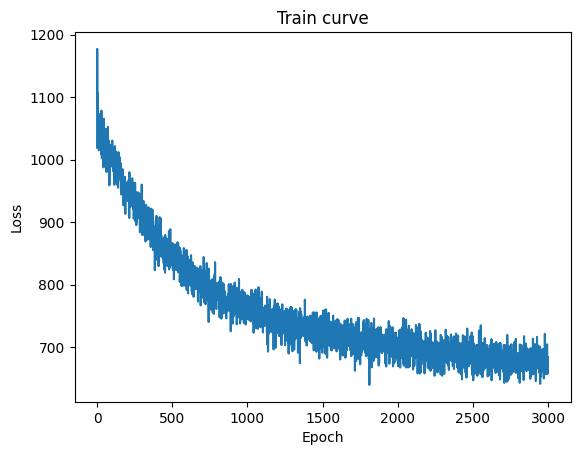

In [36]:
plt.plot(*zip(*train_history))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train curve")
plt.show()

In [ ]:
model.eval()
generate(model=model)